In [1]:
import random
import numpy as np
import operator
import pandas as pd
from datetime import datetime, timedelta
import pickle
import time

In [2]:
global total_utxo
global total_address
global pool
global b_review_index
global v_review_index
global SR_address
global SR_UTXO

In [3]:
class UTXO(object):
    def __init__(self, value, address):
        self.value = value
        self.address = address

class Address(object):
    def __init__(self, id, utxo_set):
        self.id = id
        self.utxo_set = utxo_set
    def get_utxo(self, new_utxo):
        self.utxo_set.append(new_utxo)
        total_UTXO.append(new_utxo)
    def spend_utxo(self, old_utxo):
        self.utxo_set.remove(old_utxo)
        total_UTXO.remove(old_utxo)

In [4]:
class Transaction(object):
    def __init__(self, id, type, sender, to, value):
        self.id = id
        self.type = type
        self.sender = sender
        self.to = to
        self.value =value

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import random

dx = pd.read_excel('datas.xlsx')
datar = []
for i in range(len(dx)):
    tmp = [dx["ID"][i], dx["Value"][i], dx["Date"][i]]
    ttmp = datetime.strptime(str(tmp[2]), "%Y%m%d")
    tmp[2] = ttmp
    datar.append(tmp)

data = []
for v in datar:
    if v not in data:
        data.append(v)

data_t = [d[2] for d in data]
start = min(data_t)
end = max(data_t)

r_data_index = np.random.choice(range(len(data)), 100, replace=False)
r_data = []

for r_index in r_data_index:
    data[r_index][1] = round(data[r_index][1] * pow(10, 8))
    r_data.append(data[r_index])

b_review_index = []
v_review_index = []

for rd in r_data:
    time_difference = int((rd[2] - start).days) * 5120

    if time_difference > 0:
        br = random.choice(range(time_difference))
        while br in b_review_index:
            br = random.choice(range(time_difference))
        b_review_index.append(br)

        t_max = time_difference + 71680
        if t_max > 669999:
            t_max = 669999
        rv = random.choice(range(time_difference, t_max))
        while rv in v_review_index:
            rv = random.choice(range(time_difference, t_max))
        v_review_index.append(rv)




In [6]:
def make_ov(tt, b_flag, v_flag, review_value, DT):
    if tt == "relay" or tt == "sweep":
        if b_flag:
            ov = [review_value]
        else:
            if v_flag and tt =="relay":
                not_found = True
                for v in DT:
                    if v < review_value:
                        ov = [v]
                        not_found = False
                        break
                if not_found:
                    ov = [review_value]
            else:
                ov = [random.choice(DT)]
            
    else:
        if v_flag and (tt == "distribution" or tt == "peel1"):
            for vlist in DT:
                not_found = True
                if sum(vlist) < review_value:
                    ov = vlist
                    not_found = False
                    break
                if not_found:
                    ov = random.choice(DT)
        else:
            ov = random.choice(DT)
        
        if b_flag:
            ov = [review_value] + ov
    return ov

In [7]:
def utxo_list_sum(utxo_list):
    utxo_sum = 0
    for u in utxo_list:
        utxo_sum += u.value
    return utxo_sum

In [8]:
def find_utxos(tt, i, v_flag, review_value, ov_sum):
    spending_utxo = []
    
    if tt == "relay" or tt == "distribution" or tt == "peel1":
        if v_flag:
            sra = pool[b_review_index[v_review_index.index(i)]].to[0]
            spending_utxo.append(sra.utxo_set[0])
        else:
            not_found = True
            for u in total_UTXO:
                if (u.value > ov_sum) and (u not in SR_UTXO):
                    spending_utxo.append(u)
                    not_found = False
                    break
            if not_found:
                a = Address( len(total_Address) , [] )
                new_utxo = UTXO( int(ov_sum) , a )
                a.get_utxo(new_utxo)
                total_Address.append(a)
                spending_utxo.append(new_utxo)
                
    else:
        iv_sum = 0
        for j in range(2):
            su = random.choice(total_UTXO)
            while (su in SR_UTXO) or (su in spending_utxo):
                su = random.choice(total_UTXO)
            spending_utxo.append(su)
            iv_sum += su.value
            
        if iv_sum < ov_sum:
            a = Address( len(total_Address) , [] )
            new_utxo = UTXO( int(ov_sum-iv_sum) , a )
            a.get_utxo(new_utxo)
            total_Address.append(a)
            spending_utxo.append(new_utxo)
        
        if v_flag:
            sra = pool[b_review_index[v_review_index.index(i)]].to[0]
            spending_utxo = [sra.utxo_set[0]] + spending_utxo
            
    return spending_utxo 

In [9]:
matched_address = [16754, 279454, 36005, 44385, 587945]  
SR_address = [12353, 28075, 38876, 70] 
def make_to(tt, b_flag, oc, GNA_p):
    to = []
    for i in range(oc):
        if i == 0 and b_flag:
            a = Address( len(total_Address) , [] )
            total_Address.append(a)
            SR_address.append(a)
            to.append(a)
        else:
            GNA_bool = np.random.choice([True, False], p=GNA_p)
            if GNA_bool:
                a = Address( len(total_Address) , [] )
                total_Address.append(a)
                to.append(a)
            else:
                a = random.choice(total_Address)
                while a in SR_address:
                    a = random.choice(total_Address)
                to.append(a)
    return to

In [10]:
matched_address = []
for rd in r_data:
    D = int((rd[2]-min(data_t)).days)*5120
    V = rd[1]
    otxca = []
    pool=[]
    itxca = []
    ma = []
    
    for tx in pool[:D]:
        if V in tx.value[1]:
            otxca.append(tx.to[tx.value[1].index(V)])
            
    smax = D+14*5120
    if smax > len(pool):
        smax = len(pool)-1
    for tx in pool[D:smax]:
        if V in tx.value[0]:
            itxca.append(tx.sender[tx.value[0].index(V)])
    ca = list(set(otxca) & set(itxca))
    total_address=[]
    for a in ca:
        ic = 0
        oc = 0
        fail = False
        for tx in pool:
            if (ic > 1) or (oc > 1):
                fail = True
                break
            if a in tx.sender:
                ic += 1
            if a in tx.to:
                oc += 1
        if fail:
            continue
        if (ic == 1) and (oc == 1):
            ma.append(a)
            
    if len(ma) == 1:
        matched_address.append(ma[0])

In [11]:
total_address=[]
SR_address=[matched_address, total_address ]

In [12]:
SR_address_tuples = [tuple(addr) for addr in SR_address]
matched_address_tuples = [tuple(addr) for addr in matched_address]
FN_address = list(set(SR_address_tuples) - set(matched_address_tuples))


In [13]:
for fna in FN_address:
    for tx in pool:
        if fna in tx.sender:
            print(tx.value[0][tx.sender.index(fna)])

In [14]:
count = 0
for ma in matched_address:
    if ma in SR_address:
        count+=1


In [15]:
TP = 10
FP = len(matched_address) - TP
FN = len(SR_address) - len(matched_address)


Recall = TP / max((TP + FN), 1)  


denominator_precision = TP + FP
if denominator_precision != 0:
    Precision = TP / denominator_precision
    F1_Score = 2 * (Recall * Precision) / max((Recall + Precision), 1) 
else:
    print('')
    


In [16]:
class Cluster(object):
    def __init__(self, id, address_set):
        self.id = id
        self.address_set = address_set
        
    def address_num(self):
        return len(self.address_set)    
    
    def cluster_sum(self, other_cluster):
        sas = set(self.address_set)
        ocas = set(other_cluster.address_set)
        if sas - ocas != sas:
            self.address_set = list(sas | ocas)
            clusters.remove(other_cluster)

In [17]:
global clusters
clusters = []

for tx in pool:
    if tx.type == "sweep":
        c = Cluster(len(clusters), tx.sender)
        clusters.append(c)
        
    if tx.type == "peel1":
        if tx.value[1][0] > tx.value[1][1]:
            p_index = 1
        else:
            p_index = 0
        c = Cluster(len(clusters), tx.sender + [tx.to[p_index]])
        clusters.append(c)
        
for c in clusters:
    for i in range(clusters.index(c)+1, len(clusters)):
        if i >= len(clusters):
            break
        c.cluster_sum(clusters[i])

In [18]:
SR_clusters = []
for ma in matched_address:
    for c in clusters:
        if ma in c.address_set:
            SR_clusters.append(c)


1FfmbHfnpaZjKFvyi1okTjJJusN455paPH
bc1qf2yvj48mzkj7uf8lc2a9sa7w983qe256l5c8fs
bc1qa5wkgaew2dkv56kfvj49j0av5nml45x9ek9hz6
361yogPsasxJz6JAaFskmWZes14Gs38ikj
bc1q77n0v3rsx5vp3quax6p2j6va42qspf0ydl7gup
bc1qlhw4zu27qm4tf8pvz6427sslfc4zcjkfkhvdns
3Jr3TMoLBJ7ZWA1tzJKTK91VAHNtnYeetD
3Gst5XtyQPjsiKdmGVLThei9vJsBhhe4s2
3D8D7NzLcg7BmsBCH3QY5HGweU2SGG9GRn
bc1qshje9hcvrzgp63dgl39gp27mmpqtc9vtz96znu
bc1qt9j0k9x53s5m7qxfexcc4cvwnz6dweduh7p29x
bc1qw04nfmxnj2pe8arlz5tgdpytf2322l2h82v3yn
bc1passxg28gzc60r26rjxzfkkw82djnfkyeqfzc859fqpuf0j4d2tlqg7tu6m
3NNdZst9JBvSy8kFdGYdLymF1Y6NjrtpHR
1McHUAYH5KRyN2gzNHUfZ7DWr4n6nX69Tp
31uMDqrRGj9PHAV23bt85UDuU5no2UahW1
35cioL9BkRqWk1ETj7LW7yGoyYdHZJHvUw
35vxNNKVuTuLq8pDDY7oUeFeQajdFcEui1
37hfoByqU4N6WCEigxncMUiE3tmmFZPV2q
37ZK3pHouJ6TnwNiEPVgjGVkzdC4dwhXC7
385z2hnShhWd7ZenKxwqAt6cxS9CwJKwsG
38ds2FtHRSppvqtWUptZB9JKAKXb9QrQm1
38sT4iJWiNX5M8DyJUUFgBNPKichR8sRvE
38y7BZFRuQoBaR481XpeRPtFS4ZrjaVDj7
3A5625sib4ArLDttKybSh5rYdiwgZre7uo
3AkYy5fmXNj59BtoiAke6b64vVrqrXNmE8
3AN5Qz

c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


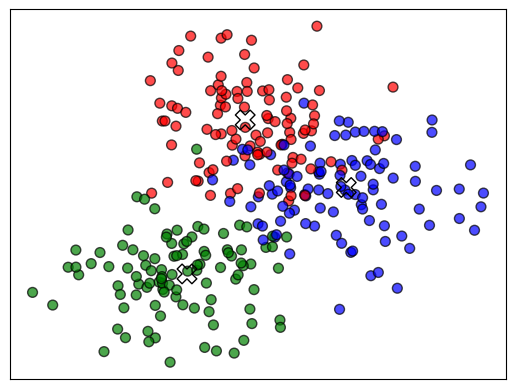

In [20]:
#len(total_Address)
%run maximaoutput.ipynb
%run address-matching-clustring.ipynb